## Robust Multi-Objective Bayesian Optimization Under Input Noise

In this tutorial, we illustrate how to perform robust multi-objective Bayesian optimization (BO) under input noise.

This is a simple tutorial; for support for constraints, batch sizes greater than 1, and many alternative methods, please see https://github.com/facebookresearch/robust_mobo.

We consider the problem of optimizing (maximizing) a vector-valued objective function $\mathbf f(\mathbf x)$ where at implementation time $\mathbf f(\mathbf x)$ is subject to input noise $\mathbf{f}(\mathbf{x} \diamond \mathbf{\xi})$ where $\mathbf{\xi} \sim P(\mathbf \xi | \mathbf x)$ is the random input noise and $\diamond$ denotes the perturbation function (e.g. addition, multiplication, or any arbitrary function).

We consider the scenario where:
1. We have access to a simulator during optimization such that $\mathbf{f}$ can be queried at a given design $\mathbf x$ without input noise.
2. Input noise is only present at implementation time. After optimization, the design that is chosen according to the decision maker's preferences will be subject to input noise.
3. The perturbation function is known.
4. We can sample from the generative process $P(\mathbf \xi | \mathbf x)$.

Quantifying risk is important to understand how the final selected design will perform under input noise.

To quantify risk in the multi-objective setting, the MVaR set is an appealing option. For a given design $\mathbf x$, MVaR is theis the set of points such that for every $\mathbf z$ in the MVaR set, $\mathbf z$ is Pareto dominated by the objectives under input noise $\mathbf f (\mathbf x \diamond \mathbf \xi)$ with probability $\alpha$. In other words, if  $\mathbf x$ is the chosen final design, the objectives will be better than $\mathbf z$ with probability $\alpha$ for all $\mathbf z$ in the MVaR set.

![MVaR](attachment:1d_toy_mvar_single_designs_combined.png "MvaR")

However, during optimization we are interested in identifying the global MVaR set that is the optimal set of probabilistic lower bounds across all designs. The global MVaR set is the non-dominated set of points across the union of MVaR sets of all points in the design space. See [1] for a deeper discussion.

In this tutorial, we will optimize the 2 1-dimensional functions shown above to identify an approximate global MVaR set. See [1] for a description of these functions.

To do so, we will use Bayesian optimization with MARS (MVaR approximated via random scalarizations). MARS exploits the result in [1] that, under limited assumptions, there is a bijection between weights in the $M-1$-dimensional-simplex (where $M$ is the number of objectives) and points $\mathbf z$ in the MVaR set based on the value-at-risk (VaR) of a Chebyshev scalarization. 

![bijection](attachment:bijection_plots.png "bijection")

MARS leverages this result to efficiently identify the MVaR set using Bayesian optimization by, at each iteration, sampling a random Chebyshev scalarization and selecting the new design with maximum acquisition value with respect to the value-at-risk
of the sampled scalarization.

[1] [S. Daulton, S. Cakmak, M. Balandat, M. A.  Osborne, E. Zhou, and E. Bakshy. Robust Bayesian Optimziation Under Input Noise. ICML, 2022.](https://arxiv.org/abs/2202.07549)
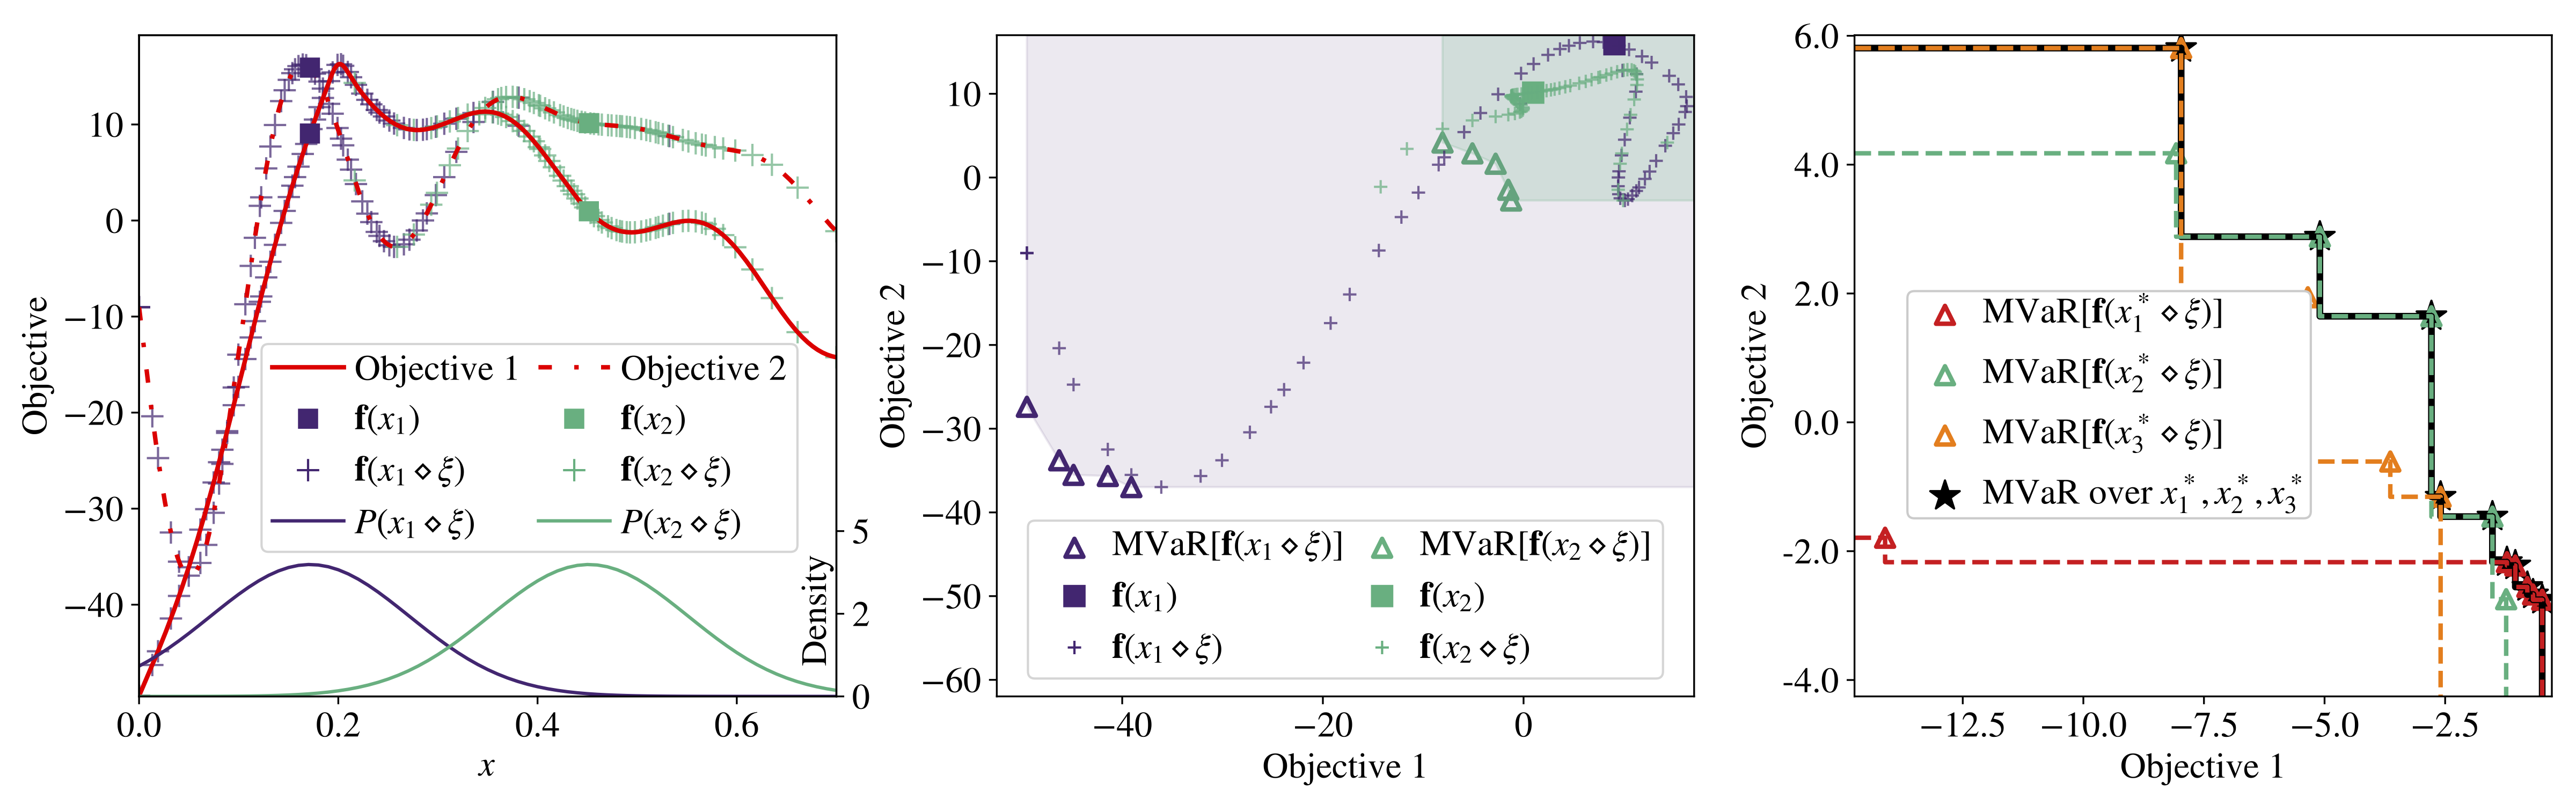
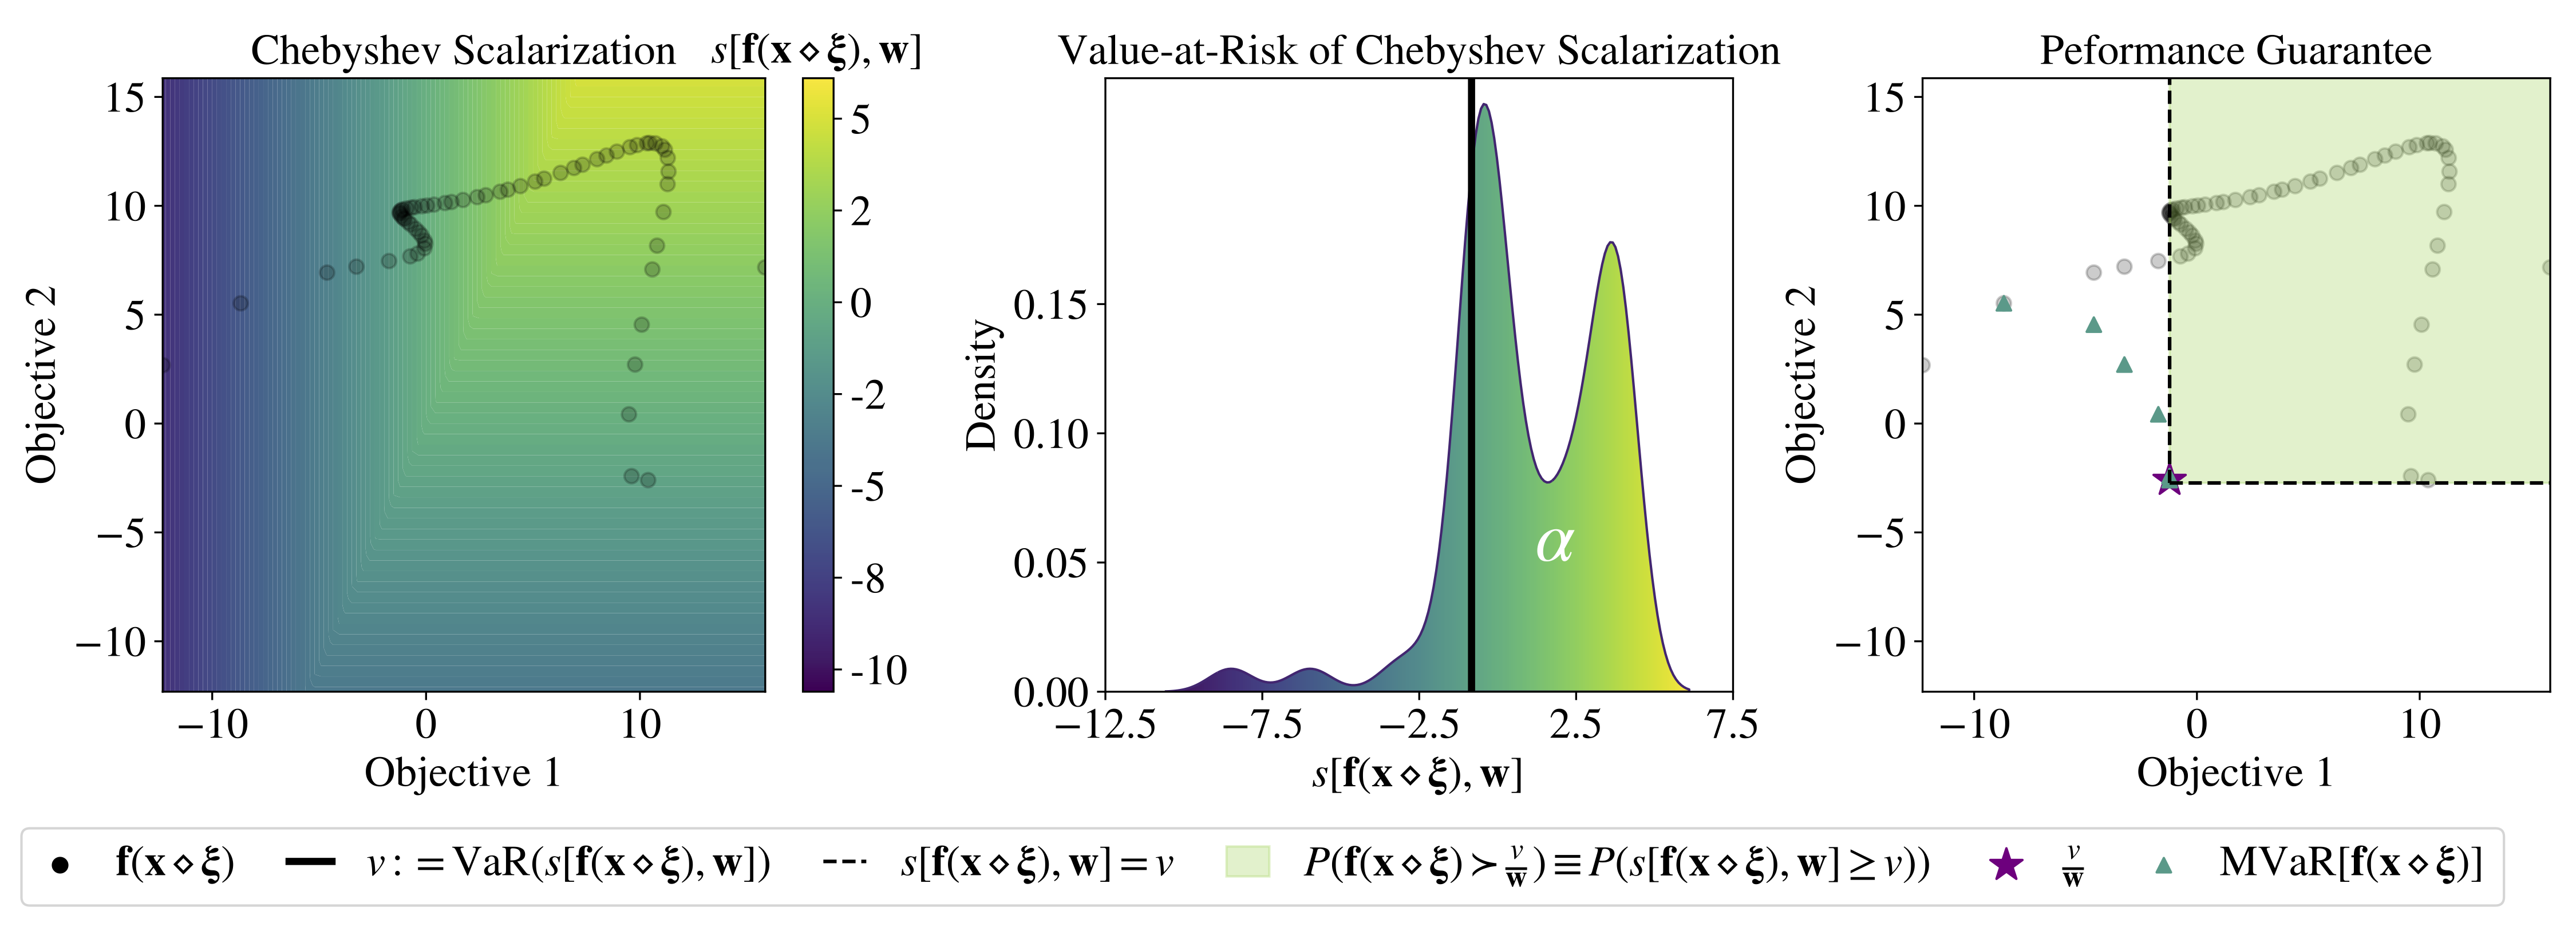

In [1]:
import torch
import numpy as np
import os

tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda:2" if torch.cuda.is_available() else "cpu"),
}
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
SMOKE_TEST = os.environ.get("SMOKE_TEST")

## Configure the problem and optimization

In [2]:
from botorch.test_functions.multi_objective import ToyRobust

base_function = ToyRobust(negate=True).to(**tkwargs)  # define test function
bounds = base_function.bounds
n_w = (
    2 if SMOKE_TEST else 32
)  # number of MC samples for approximating input noise distribution
alpha = 0.9  # probability level
std_dev = 0.1  # zero-mean quasi-Normal input noise, with a standard deviation of 0.1
search_space_range = bounds[1] - bounds[0]
# scale the specified std_dev to a unit cube search space
scaled_std_dev = (
    torch.tensor(std_dev, dtype=bounds.dtype, device=bounds.device) / search_space_range
)
mc_samples = 2 if SMOKE_TEST else 256  # number of samples for MC acquisition functions
hv_n_w = (
    2 if SMOKE_TEST else 512
)  # number of MC samples for approximating input noise distribution for omniscient evaluation
mvar_ref_point = torch.tensor(
    [-14.1951, -3.1887], **tkwargs
)  # reference point for the MVaR frontier
# options for acquisition optimization
options = {
    "batch_limit": 5,  # number of starting points to jointly optimize in L-BFGS-B
    "maxiter": 2 if SMOKE_TEST else 200,  # maximum number of L-BFGS-B iterations
}
optimization_kwargs = {
    "num_restarts": 2 if SMOKE_TEST else 20,  # number of random restarts for L-BFGS-B
    "raw_samples": 10
    if SMOKE_TEST
    else 1024,  # number of random samples for initialization heuristic
    "options": options,
}
iterations = 1 if SMOKE_TEST else 5  # number of BO iterations
verbose = True
n_initial_points = 4  # number of initial sobol points

## Create a function for evaluating the objectives.
We work in a search space that is normalized to the unit cube and only unnormalize the search space to evaluate the objectives.

In [3]:
from botorch.utils.transforms import unnormalize

# define function for evaluation
def eval_problem(X):
    X = unnormalize(X, base_function.bounds)
    return base_function(X)

## Create a function for sampling initial quasi-random points from the unit cube

In [4]:
from botorch.utils.sampling import draw_sobol_samples

standard_bounds = torch.ones(2, base_function.dim, **tkwargs)
standard_bounds[0] = 0


def generate_initial_data(
    n,
    eval_problem,
    bounds,
    tkwargs,
):
    r"""
    Generates the initial data for the experiments.
    Args:
        n: Number of training points.
        eval_problem: The callable used to evaluate the objective function.
        bounds: The bounds to generate the training points from. `2 x d`-dim tensor.
        tkwargs: Arguments for tensors, dtype and device.
    Returns:
        The train_X and train_Y. `n x d` and `n x m`.
    """
    train_x = draw_sobol_samples(bounds=bounds, n=n, q=1).squeeze(-2).to(**tkwargs)
    train_obj = eval_problem(train_x)
    return train_x, train_obj

## Create a utility module for evaluating the hypervolume of the MVaR frontier

We can evaluate the quality of an MVaR frontier by measuring the hypervolume dominated by the MVaR frontier and bounded from below by a reference point.

In [5]:
from botorch.acquisition.multi_objective.multi_output_risk_measures import MVaR
from botorch.utils.multi_objective.box_decompositions.dominated import (
    DominatedPartitioning,
)
from botorch.models.transforms.input import InputPerturbation


class MVaRHV(torch.nn.Module):
    r"""A helper class that calculates the HV of the MVaR set."""

    def __init__(
        self,
        alpha,
        eval_problem,
        ref_point,
        n_w,
        perturbation_set,
    ):
        super().__init__()
        self.hv = DominatedPartitioning(ref_point=ref_point)
        self.mvar = MVaR(n_w=n_w, alpha=alpha)
        self.perturbation = InputPerturbation(
            perturbation_set=perturbation_set,
        ).eval()
        self.eval_problem = eval_problem

    def forward(self, new_X):
        r"""Calculate the resulting HV by adding the MVaR corresponding to the new_X
        to the Pareto set.
        Args:
            new_X: `q x dim`-dim tensor of candidate points.
        Returns:
            The cumulative MVaR HV of all points evaluated so far.
        """
        # Get the corresponding MVaR set.
        perturbed_X = self.perturbation(new_X)
        perturbed_Y = self.eval_problem(perturbed_X)
        new_mvar = self.mvar(perturbed_Y).view(-1, perturbed_Y.shape[-1])
        # Update and return the new MVaR HV.
        self.hv.update(new_mvar)
        return self.hv.compute_hypervolume().item()

## Create a method for initializing the surrogate model

In [6]:
from botorch.models.gp_regression import FixedNoiseGP
from botorch.models.model_list_gp_regression import ModelListGP
from gpytorch.mlls import SumMarginalLogLikelihood
from botorch.models.transforms.outcome import Standardize


def initialize_model(train_x, train_y, perturbation_set):
    r"""Constructs the model and its MLL.
    Args:
        train_x: An `n x d`-dim tensor of training inputs.
        train_y: An `n x m`-dim tensor of training outcomes.
        perturbation_set: A `n_w x d`-dim tensor of perturbations
    Returns:
        The MLL and the model. Note: the model is not trained!
    """
    train_Yvar = torch.full_like(train_y, 1e-7) * train_y.std(dim=0).pow(2)
    models = []
    for i in range(train_y.shape[-1]):
        models.append(
            FixedNoiseGP(
                train_X=train_x,
                train_Y=train_y[..., i : i + 1],
                train_Yvar=train_Yvar[..., i : i + 1],
                outcome_transform=Standardize(m=1),
                input_transform=InputPerturbation(perturbation_set=perturbation_set),
            )
        )
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)

    return mll, model

## Create a method for initializing MARS-NEI

We use the MARS approach with the NEI acquisition function as in [1].

In [7]:
from botorch.acquisition.multi_objective.multi_output_risk_measures import MARS
from botorch.acquisition.monte_carlo import qNoisyExpectedImprovement
from botorch.utils.sampling import sample_simplex


def get_MARS_NEI(
    model,
    n_w,
    X_baseline,
    sampler,
    mvar_ref_point,
):
    r"""Construct the NEI acquisition function with VaR of Chebyshev scalarizations.
    Args:
        model: A fitted multi-output GPyTorchModel.
        n_w: the number of perturbation samples
        X_baseline: An `r x d`-dim tensor of points already observed.
        sampler: The sampler used to draw the base samples.
        mvar_ref_point: The mvar reference point.
    Returns:
        The NEI acquisition function.
    """
    # sample weights from the simplex
    weights = sample_simplex(
        d=mvar_ref_point.shape[0],
        n=1,
        dtype=X_baseline.dtype,
        device=X_baseline.device,
    ).squeeze(0)
    # set up mars objective
    mars = MARS(
        alpha=alpha,
        n_w=n_w,
        chebyshev_weights=weights,
        ref_point=mvar_ref_point,
    )
    # set normalization bounds for the scalarization
    mars.set_baseline_Y(model=model, X_baseline=X_baseline)
    # initial qNEI acquisition function with the MARS objective
    acq_func = qNoisyExpectedImprovement(
        model=model,
        X_baseline=X_baseline,
        objective=mars,
        prune_baseline=True,
        sampler=sampler,
    )
    return acq_func

## Set up the optimization

In [8]:
# Get the initial data.
X, Y = generate_initial_data(
    n=n_initial_points,
    eval_problem=eval_problem,
    bounds=standard_bounds,
    tkwargs=tkwargs,
)

In [9]:
from botorch.utils.sampling import draw_sobol_normal_samples

# Ensure consistency of MVaRHV across seeds by using same perturbations.
# This sets the random seed and generates the perturbations on CPU.
# MVaR calculations are also moved to CPU.
old_state = torch.random.get_rng_state()
torch.manual_seed(0)
perturbations = (
    draw_sobol_normal_samples(d=base_function.dim, n=hv_n_w, **tkwargs) * scaled_std_dev
)
mvar_hv = MVaRHV(
    alpha=alpha,
    eval_problem=eval_problem,
    ref_point=torch.tensor(mvar_ref_point, **tkwargs),
    n_w=hv_n_w,
    perturbation_set=perturbations,
)
torch.random.set_rng_state(old_state)

In [10]:
try:
    all_mvar_hvs = torch.tensor([mvar_hv(X)], dtype=tkwargs["dtype"])
except RuntimeError:
    # Try to feed them one by one. This helps with memory.
    initial_mvar_hv = 0.0
    for j in range(X.shape[0]):
        initial_mvar_hv = mvar_hv(X[j : j + 1])
    all_mvar_hvs = torch.tensor([initial_mvar_hv], dtype=tkwargs["dtype"])

## Run BO with MARS

In [11]:
import gc
import gpytorch.settings as gpt_settings
from time import time
from botorch.fit import fit_gpytorch_mll
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.optim.optimize import optimize_acqf

start = time()
for i in range(iterations):
    if verbose:
        print(
            f"Starting iteration {i}, "
            f"time: {time()-start}, current MVaR HV: {all_mvar_hvs[-1]}."
        )

    # Generate the perturbations for evaluation
    perturbation_set = (
        draw_sobol_normal_samples(d=base_function.dim, n=n_w, **tkwargs)
        * scaled_std_dev
    )
    # Fit the model.
    mll, model = initialize_model(
        train_x=X, train_y=Y, perturbation_set=perturbation_set
    )
    fit_gpytorch_mll(mll)

    with gpt_settings.cholesky_max_tries(6):
        # Construct the acqf.
        sampler = SobolQMCNormalSampler(sample_shape=torch.Size([mc_samples]))
        acq_func = get_MARS_NEI(
            model=model,
            n_w=n_w,
            X_baseline=X,
            sampler=sampler,
            mvar_ref_point=mvar_ref_point,
        )

        # Optimize the acqf.
        while options["batch_limit"] >= 1:
            # Try to get around OOM by reducing batch_limit.
            try:
                torch.cuda.empty_cache()
                candidates, _ = optimize_acqf(
                    acq_function=acq_func,
                    bounds=standard_bounds,
                    q=1,
                    **optimization_kwargs,
                )
                torch.cuda.empty_cache()
                break
            except RuntimeError as e:
                if options["batch_limit"] > 1:
                    print(
                        "Got a RuntimeError in `optimize_acqf`. "
                        "Trying with reduced `batch_limit`."
                    )
                    options["batch_limit"] //= 2
                    continue
                else:
                    raise e
    # free memory
    del acq_func, mll, model
    gc.collect()
    torch.cuda.empty_cache()

    # Get the new observations and update the data.
    new_y = eval_problem(candidates)
    X = torch.cat([X, candidates], dim=0)
    Y = torch.cat([Y, new_y], dim=0)
    new_mvar_hv = mvar_hv(candidates)
    all_mvar_hvs = torch.cat(
        [all_mvar_hvs, torch.tensor([new_mvar_hv], dtype=tkwargs["dtype"])], dim=0
    )

Starting iteration 0, time: 0.00027441978454589844, current MVaR HV: 42.430757642706055.


/data/sandcastle/boxes/fbsource/buck-out/v2/gen/fbcode/f3b9a99e517e0a13/bento/kernels/__bento_kernel_axoptics__/bento_kernel_axoptics#link-tree/gpytorch/likelihoods/noise_models.py:144: NumericalWarning:

Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.



Starting iteration 1, time: 9.476728200912476, current MVaR HV: 85.50895176532245.


/data/sandcastle/boxes/fbsource/buck-out/v2/gen/fbcode/f3b9a99e517e0a13/bento/kernels/__bento_kernel_axoptics__/bento_kernel_axoptics#link-tree/gpytorch/likelihoods/noise_models.py:144: NumericalWarning:

Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.



/data/sandcastle/boxes/fbsource/buck-out/v2/gen/fbcode/f3b9a99e517e0a13/bento/kernels/__bento_kernel_axoptics__/bento_kernel_axoptics#link-tree/botorch/optim/optimize.py:306: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal')]
Trying again with a new set of initial conditions.



Starting iteration 2, time: 24.17291235923767, current MVaR HV: 87.13964153247537.


/data/sandcastle/boxes/fbsource/buck-out/v2/gen/fbcode/f3b9a99e517e0a13/bento/kernels/__bento_kernel_axoptics__/bento_kernel_axoptics#link-tree/gpytorch/likelihoods/noise_models.py:144: NumericalWarning:

Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.

/data/sandcastle/boxes/fbsource/buck-out/v2/gen/fbcode/f3b9a99e517e0a13/bento/kernels/__bento_kernel_axoptics__/bento_kernel_axoptics#link-tree/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal



Starting iteration 3, time: 29.630997896194458, current MVaR HV: 87.148383606772.


/data/sandcastle/boxes/fbsource/buck-out/v2/gen/fbcode/f3b9a99e517e0a13/bento/kernels/__bento_kernel_axoptics__/bento_kernel_axoptics#link-tree/gpytorch/likelihoods/noise_models.py:144: NumericalWarning:

Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.



/data/sandcastle/boxes/fbsource/buck-out/v2/gen/fbcode/f3b9a99e517e0a13/bento/kernels/__bento_kernel_axoptics__/bento_kernel_axoptics#link-tree/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal



/data/sandcastle/boxes/fbsource/buck-out/v2/gen/fbcode/f3b9a99e517e0a13/bento/kernels/__bento_kernel_axoptics__/bento_kernel_axoptics#link-tree/botorch/optim/optimize.py:306: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), NumericalWarning

/data/sandcastle/boxes/fbsource/buck-out/v2/gen/fbcode/f3b9a99e517e0a13/bento/kernels/__bento_kernel_axoptics__/bento_kernel_axoptics#link-tree/botorch/optim/optimize.py:328: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.



Starting iteration 4, time: 43.48030400276184, current MVaR HV: 89.14242777378423.


/data/sandcastle/boxes/fbsource/buck-out/v2/gen/fbcode/f3b9a99e517e0a13/bento/kernels/__bento_kernel_axoptics__/bento_kernel_axoptics#link-tree/gpytorch/likelihoods/noise_models.py:144: NumericalWarning:

Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.



/data/sandcastle/boxes/fbsource/buck-out/v2/gen/fbcode/f3b9a99e517e0a13/bento/kernels/__bento_kernel_axoptics__/bento_kernel_axoptics#link-tree/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal



/data/sandcastle/boxes/fbsource/buck-out/v2/gen/fbcode/f3b9a99e517e0a13/bento/kernels/__bento_kernel_axoptics__/bento_kernel_axoptics#link-tree/botorch/optim/optimize.py:306: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal')]
Trying again with a new set of initial conditions.



/data/sandcastle/boxes/fbsource/buck-out/v2/gen/fbcode/f3b9a99e517e0a13/bento/kernels/__bento_kernel_axoptics__/bento_kernel_axoptics#link-tree/botorch/optim/optimize.py:328: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.



## Evaluate Results

First we evaluate the hypervolume dominated by the MvaR frontier and bounded from below by the reference point. A larger hypervolume means a better MVaR frontier.

Text(0.5, 0, 'BO Iterations')

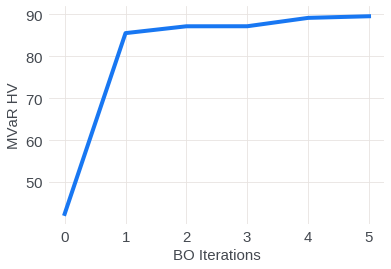

In [12]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.plot(torch.arange(all_mvar_hvs.shape[0]), all_mvar_hvs)
plt.ylabel("MVaR HV")
plt.xlabel("BO Iterations")

Next, we plot the mvar frontier to see the possible probabilistic lower bounds. For each point $\mathbf z$ in the MVaR set, there is a previously evaluated design that will be at least as good as $\mathbf z$ with probability $\alpha$.

In [15]:
from botorch.utils.multi_objective.pareto import is_non_dominated

# Evaluate true MVaR
# Perturb X
perturbed_X = mvar_hv.perturbation(X)
# Compute objectives at perturbed points
true_Y_under_noise = eval_problem(perturbed_X)
# calculate the MVaR frontier for each point X
mvar_points = mvar_hv.mvar(true_Y_under_noise)
# calculate the pareto frontier over the union of individual MVaR frontiers for each design
mvar_frontier = mvar_points[is_non_dominated(mvar_points)].cpu()

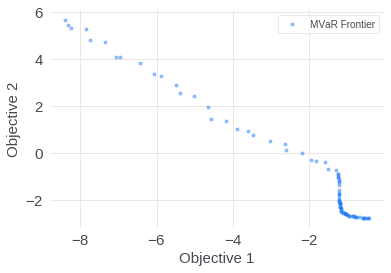

In [16]:
plt.plot(
    mvar_frontier[:, 0], mvar_frontier[:, 1], ".", alpha=0.4, label="MVaR Frontier"
)
plt.xlabel("Objective 1")
plt.ylabel("Objective 2")
plt.legend()

Finally, we can plot the MVaR frontier for each evaluated design. Clearly some designs are far more robust than others under input noise.

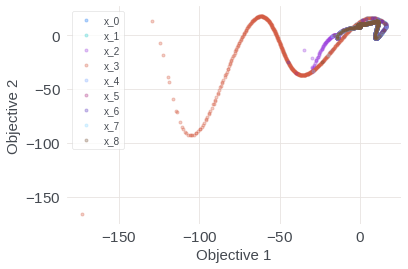

In [18]:
for i, y in enumerate(true_Y_under_noise.view(X.shape[0], hv_n_w, -1).cpu()):
    plt.plot(y[:, 0], y[:, 1], ".", color=f"C{i}", label=f"x_{i}", alpha=0.3)
plt.xlabel("Objective 1")
plt.ylabel("Objective 2")
plt.legend()